In [ ]:
# Labhaoise Mullins (20266928)
# Gerard O'Connell (19192118)

In [ ]:
# This code executes to the end without error

In [ ]:
# Link to dataset (Kaggle)
# https://kaggle.com/datasets/quanbk/cifar10/data

In [ ]:
# Import all of the necessary libraries
# To process the dataset
import pandas as pd
import numpy as np

# To plot the model and dataset
import matplotlib.pyplot as plt
%matplotlib inline

# Import TensorFlow - training of deep neural networks
import tensorflow as tf

# Import the load_model function
from tensorflow.keras.models import load_model

# Import the optimisers
from keras import optimizers
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adamax, Adadelta, Adafactor, Ftrl, Nadam, AdamW
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam

# Import for splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Access and load the CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10

# Import function for multi-class classification tasks in Keras
from tensorflow.keras.utils import to_categorical

# Imports the Sequential class from Keras
from tensorflow.keras.models import Sequential

# Import layer types - used to define the architecture of neural network
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Activation, Dropout, BatchNormalization

# Imports for Data Augmentation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import for visualising confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

# Imports for evaluating and reporting classification performance
from sklearn.metrics import classification_report, confusion_matrix

# Import necessary modules from Keras for custom layer creation and backend operations
from keras import backend as K
from keras.layers import Layer

# Import KFold for performing k-fold cross-validation
from sklearn.model_selection import KFold

# Import Loss function
from tensorflow.keras.losses import sparse_categorical_crossentropy

## Load data

In [ ]:
# Load the dataset
 (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Display the shape of the training sets
# Shape - 50,000 images, 32x32 in size, each image is in colour (3 = RGB)
print(f"X_train shape: {X_train.shape}")
# Shape - 50,000 images, each with a associated label
print(f"y_train shape: {y_train.shape}")

# Display the shape of the testing sets
# Shape - 10,000 images, 32x32 in size, each image is in colour (3 = RGB)
print(f"X_test shape: {X_test.shape}")

# Shape - 10,000 images, each with an associated label
print(f"y_test shape: {y_test.shape}")

# Split the dataset into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(f"X_train shape: {X_train.shape}")
#print(f"y_train shape: {y_train.shape}")
#print(f"X_val shape: {X_val.shape}")
#print(f"y_val shape: {y_val.shape}")


X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


## Visualisation

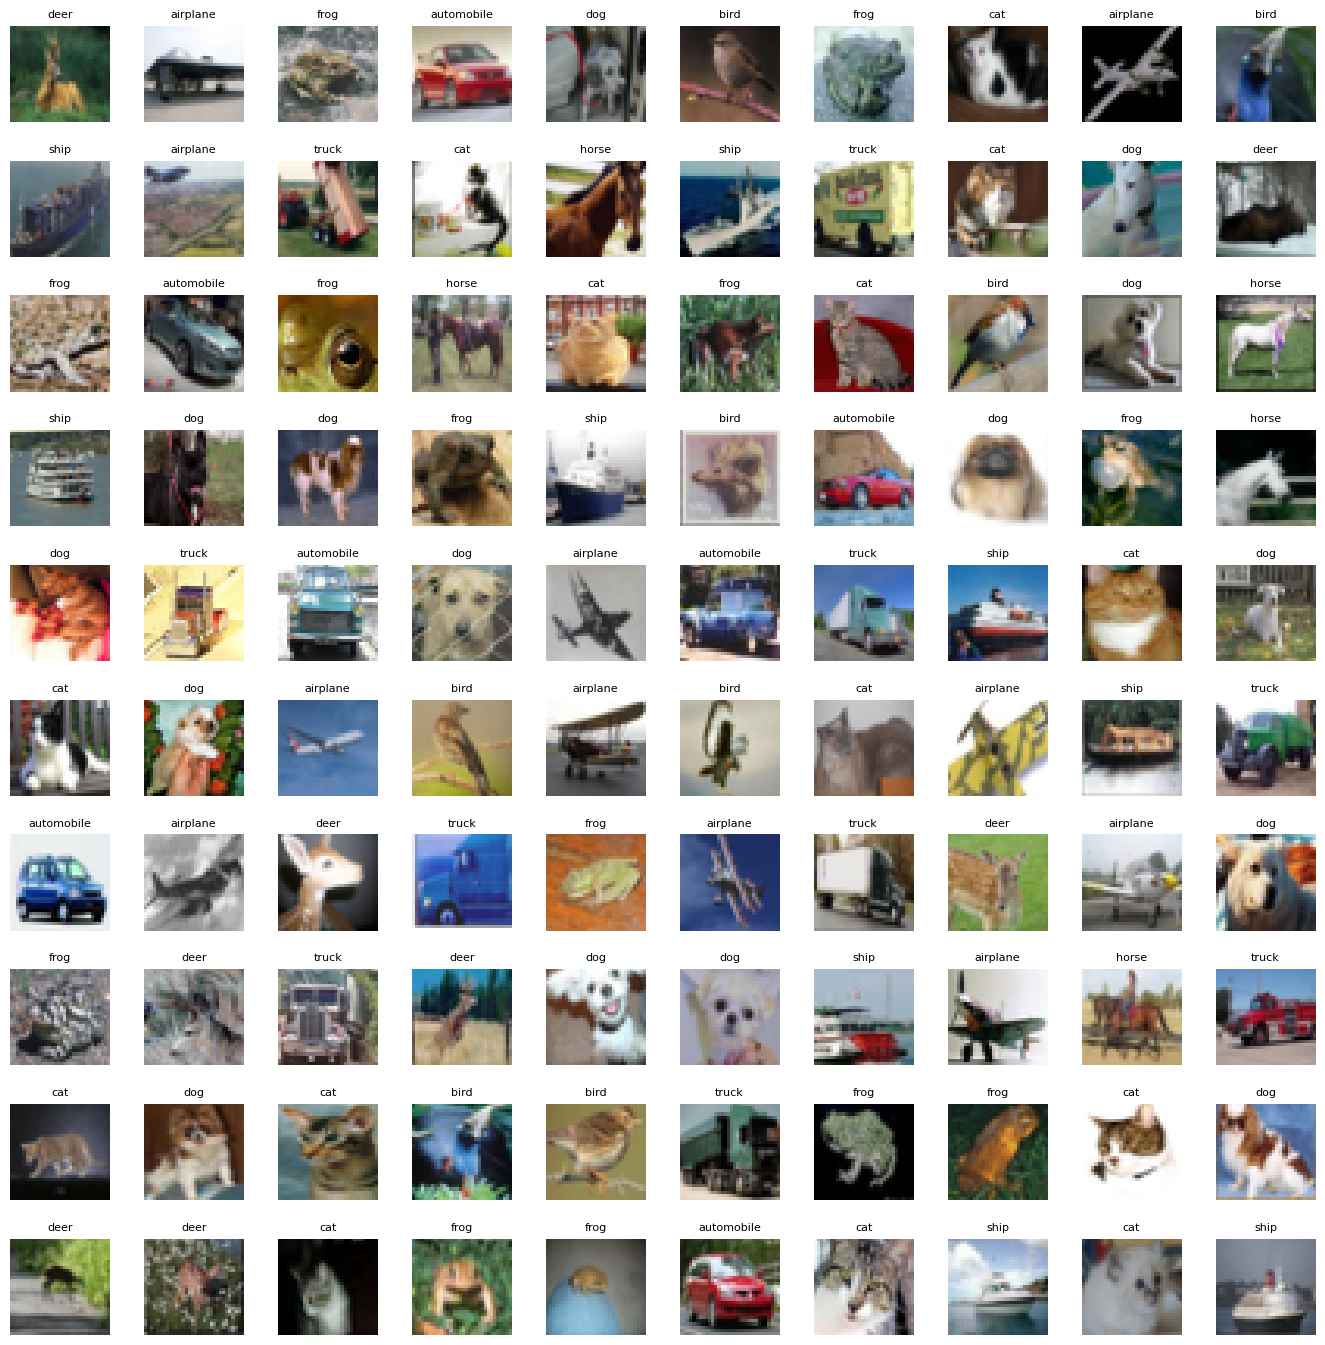

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

# Create a 17x17 grid of subplots
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

# Flaten the grid into 225 array
axes = axes.ravel()

# Get the length of the train dataset
n_train = len(X_train)

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # Create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # Read and display an image with the selected index
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8) # Label name is the title of the subplot
    axes[i].axis('off') # Hide the axis

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

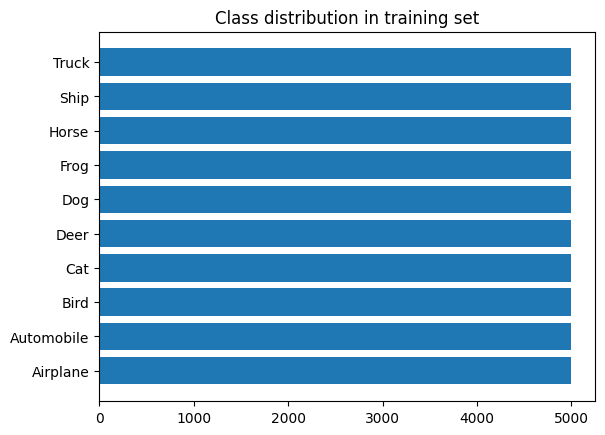

In [ ]:
# Create a bar chart to show the distribution of the classes in the training dataset
# Class names
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Find classes and their counts in the 'y_train' (labels) array
classes, counts = np.unique(y_train, return_counts=True)

# Create the horizontal bar chart
plt.barh(classes_name, counts)

# Add a title to the chart
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

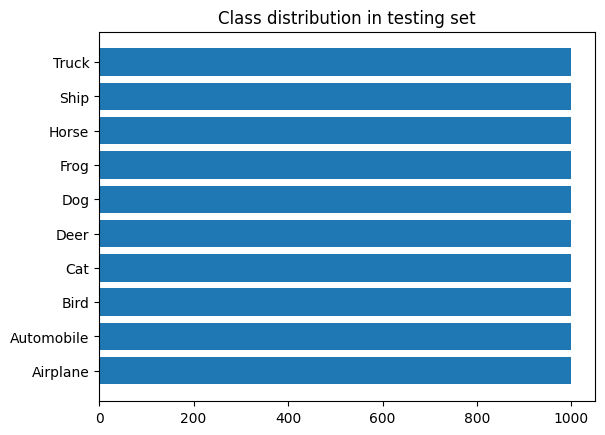

In [ ]:
# Create a bar chart to show the distribution of the classes in the testing dataset
# Find classes and their counts in the 'y_test' (labels) array
classes, counts = np.unique(y_test, return_counts=True)

# Create the horizontal bar chart
plt.barh(classes_name, counts)

# Add a title to the chart
plt.title('Class distribution in testing set')

## Data Preprocessing

In [ ]:
# Normalisation - normalise the pixel values in the image data
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

#y_bird_train = to_categorical(y_train, 10)
#y_bird_test = to_categorical(y_test, 10)

In [ ]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## The Convolutional Neural Network: AlexNet

In [ ]:
# Custom Layer - (LRN) Local Response Normalization
class LRN(Layer):
    def __init__(self, alpha=1e-4, beta=0.75, k=2, n=5, **kwargs):
      # Initialises the LRN layer with specified parameters
        self.alpha = alpha
        self.beta = beta
        self.k = k
        self.n = n
        super(LRN, self).__init__(**kwargs)

    def build(self, input_shape):
      # Builds the layer and sets the input shape
        self.shape = input_shape
        super(LRN, self).build(input_shape)

    def call(self, x, mask=None):
      # Applies LRN to the input tensor
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.n, self.n), strides=(1, 1), padding='same', pool_mode='avg')
        summed = K.sum(pooled, axis=1, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, self.shape[1], axis=1)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom

    def compute_output_shape(self, input_shape):
      # Returns the output shape
        return input_shape

In [ ]:
# Input shape is 32x32 pixels with 3 color channels
INPUT_SHAPE = (32, 32, 3)

# 10 output classes
NUM_CLASSES = 10

# Define the Model (AlexNet)
def create_model():
# Creates and initialises the model in Keras
    model = Sequential()

    # 1st Convolutional Layer
    # Add a 2D convolutional layer to the model
    model.add(Conv2D(96, (3, 3), input_shape=INPUT_SHAPE, strides=(1, 1), padding='same'))
    # Add a ReLU activation layer - replaces any negative values with zero
    model.add(Activation('relu'))
    # Add a max pooling layer - reduces the spatial dimensions of the input data by down-sampling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Add a batch normalization layer - normalizes the input of the layer by adjusting and scaling its activations
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())

    # Add Flatten ;ayer to the model
    model.add(Flatten())

    # 1st Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
   # model.add(Dense(10, activation='softmax'))

    # Compile the model for optimizer comparison
    sgd = SGD(learning_rate=0.01, momentum=0.9)

# Define a list of metrics for model evaluation
    METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

    # Compiles the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

    return model

# Creates the model
model = create_model()

# Displays the summary of the model architecture
model.summary()

# List of optimizers to compare
#optimizers = [SGD(), RMSprop(), Adagrad(), Adam(), AdamW(), Adadelta(), Adagrad(), Adamax(), Adafactor(), Nadam(), Ftrl()]


#results = {}  # Store results for each optimizer

# Iterate through each optimizer
#METRICS = [
 #   'accuracy',
 #   tf.keras.metrics.Precision(name='precision'),
#    tf.keras.metrics.Recall(name='recall')
#]
#y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
#y_test = to_categorical(y_test, num_classes=NUM_CLASSES)
#for optimizer in optimizers:
 #   model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=METRICS)
  #  history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

 #   test_results = model.evaluate(X_test, y_test)
  #  print(f"Optimizer: {optimizer.__class__.__name__}")
   # print(f"Test accuracy: {test_results[1]}")
   # print(f"Test precision: {test_results[2]}")
    #print(f"Test recall: {test_results[3]}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 96)        2688      
                                                                 
 activation_8 (Activation)   (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 16, 16, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 256)       221440    
                                                                 
 activation_9 (Activation)   (None, 16, 16, 256)      

## Data Augmentation

In [ ]:
# Early stopping - stops the training if the model performance does not improve
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
batch_size = 32

# Create an ImageDataGenerator object with augmentation configurations
data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)

# Create a data generator for training data
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)

# Calculate the number of steps per epoch
steps_per_epoch = X_train.shape[0] // batch_size

# Train the model
r = model.fit(train_generator,
              epochs=60,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test),
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/60
1562/1562 [==============================] - 80s 45ms/step - loss: 2.0139 - accuracy: 0.3829 - precision: 0.4597 - recall: 0.2873 - val_loss: 1.6364 - val_accuracy: 0.5058 - val_precision: 0.5967 - val_recall: 0.4111
Epoch 2/60
1562/1562 [==============================] - 47s 30ms/step - loss: 1.4079 - accuracy: 0.5471 - precision: 0.6326 - recall: 0.4658 - val_loss: 1.3674 - val_accuracy: 0.5868 - val_precision: 0.6620 - val_recall: 0.5209
Epoch 3/60
1562/1562 [==============================] - 47s 30ms/step - loss: 1.1896 - accuracy: 0.6182 - precision: 0.6991 - recall: 0.5457 - val_loss: 1.4851 - val_accuracy: 0.5507 - val_precision: 0.6292 - val_recall: 0.4916
Epoch 4/60
1562/1562 [==============================] - 45s 29ms/step - loss: 1.2304 - accuracy: 0.6039 - precision: 0.6926 - recall: 0.5256 - val_loss: 1.1836 - val_accuracy: 0.6041 - val_precision: 0.7330 - val_recall: 0.4974
Epoch 5/60
1562/1562 [==============================] - 44s 28ms/step - loss: 1.0912 - a

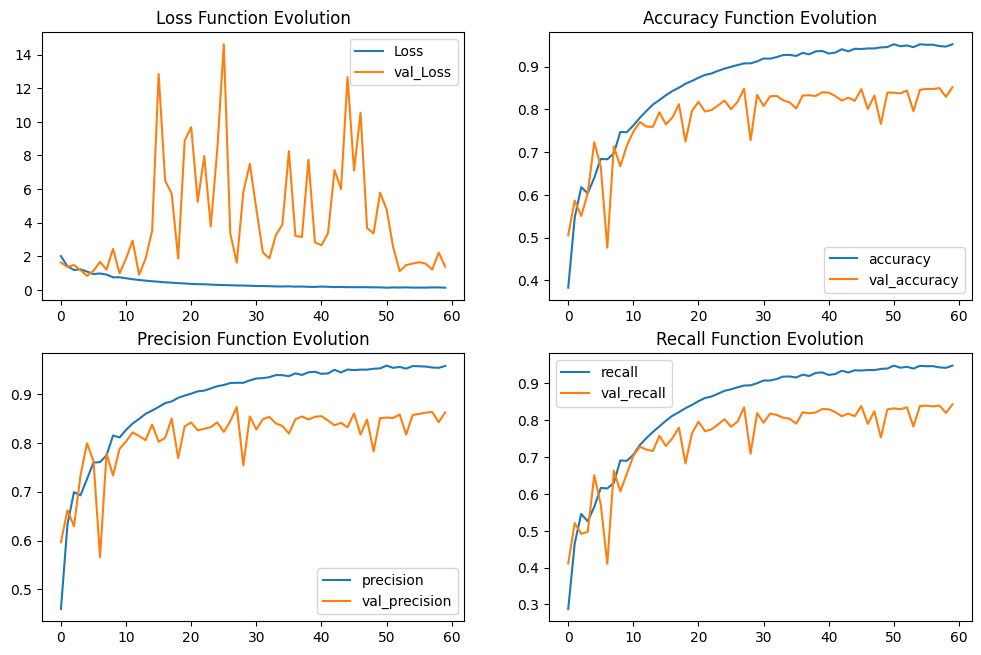

In [ ]:
# Set the figure size for the entire subplot
plt.figure(figsize=(12, 16))

# Subplot 1: Loss Function Evolution
plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

# Subplot 2: Accuracy Function Evolution
plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

# Subplot 3: Precision Function Evolution
plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

# Subplot 4: Recall Function Evolution
plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

In [ ]:
# Print the shape of the test set features (X_test)
print(f"Shape of X_test: {X_test.shape}")

# Print the shape of the test set labels (y_test)
print(f"Shape of y_test: {y_test.shape}")

# Print the shape of the categorical test set labels (y_cat_test)
print(f"Shape of y_cat_test: {y_cat_test.shape}")

# Print a sample value from the test set labels (y_test)
print(f"Sample y_test value: {y_test[0]}")

# Print a sample value from the categorical test set labels (y_cat_test)
print(f"Sample y_cat_test value: {y_cat_test[0]}")

Shape of X_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)
Shape of y_cat_test: (10000, 10)
Sample y_test value: [3]
Sample y_cat_test value: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


313/313 [==============================] - 2s 5ms/step - loss: 1.3775 - accuracy: 0.8522 - precision: 0.8625 - recall: 0.8435
Test Accuracy : 85.22%
313/313 [==============================] - 1s 3ms/step


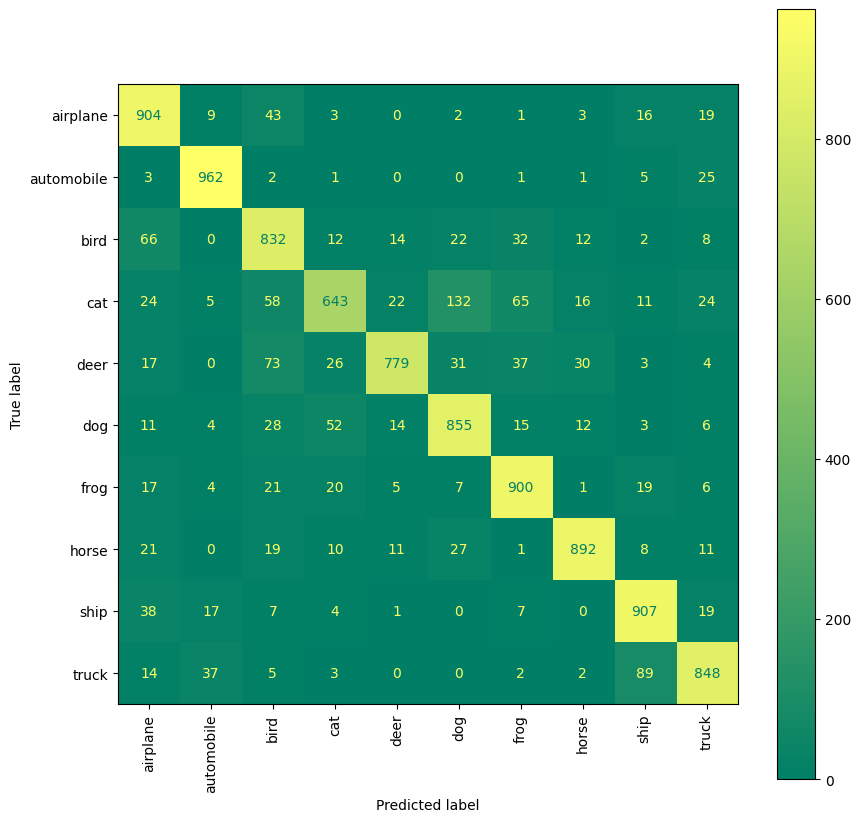

In [ ]:
# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_cat_test)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')

# Predict class labels for the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Set up the plot for confusion matrix
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

# Display the plot
plt.show()

In [ ]:
# Model Summary
model.summary()

# Ensure the label shape matches the prediction shape
# For example, if the model output is one-hot encoded:
# If the labels are in integer format
if len(y_cat_test.shape) > 1:  # Indicates one-hot encoding
    # Convert labels to categorical if not in one-hot encoded format
    y_test = np.argmax(y_cat_test, axis=1)
else:
    # One-hot encode labels if model output is categorical
    y_cat_test = to_categorical(y_test, num_classes=num_classes)  # num_classes should be defined


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 96)        2688      
                                                                 
 activation_8 (Activation)   (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 16, 16, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 256)       221440    
                                                                 
 activation_9 (Activation)   (None, 16, 16, 256)      

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1000
           1       0.93      0.96      0.94      1000
           2       0.76      0.83      0.80      1000
           3       0.83      0.64      0.72      1000
           4       0.92      0.78      0.84      1000
           5       0.79      0.85      0.82      1000
           6       0.85      0.90      0.87      1000
           7       0.92      0.89      0.91      1000
           8       0.85      0.91      0.88      1000
           9       0.87      0.85      0.86      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Test image

 Image 100 is 4
1/1 [==============================] - 0s 103ms/step
The model predict that image 100 is 4


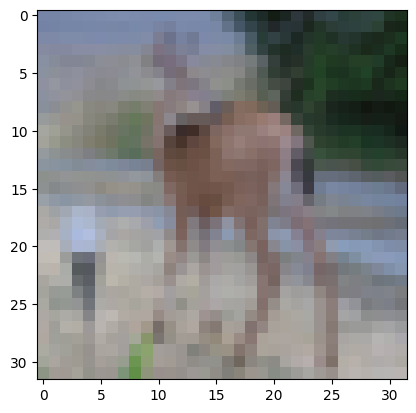

In [ ]:
my_image = X_test[100]
plt.imshow(my_image)

# That's a Deer
print(f" Image 100 is {y_test[100]}")

# Correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

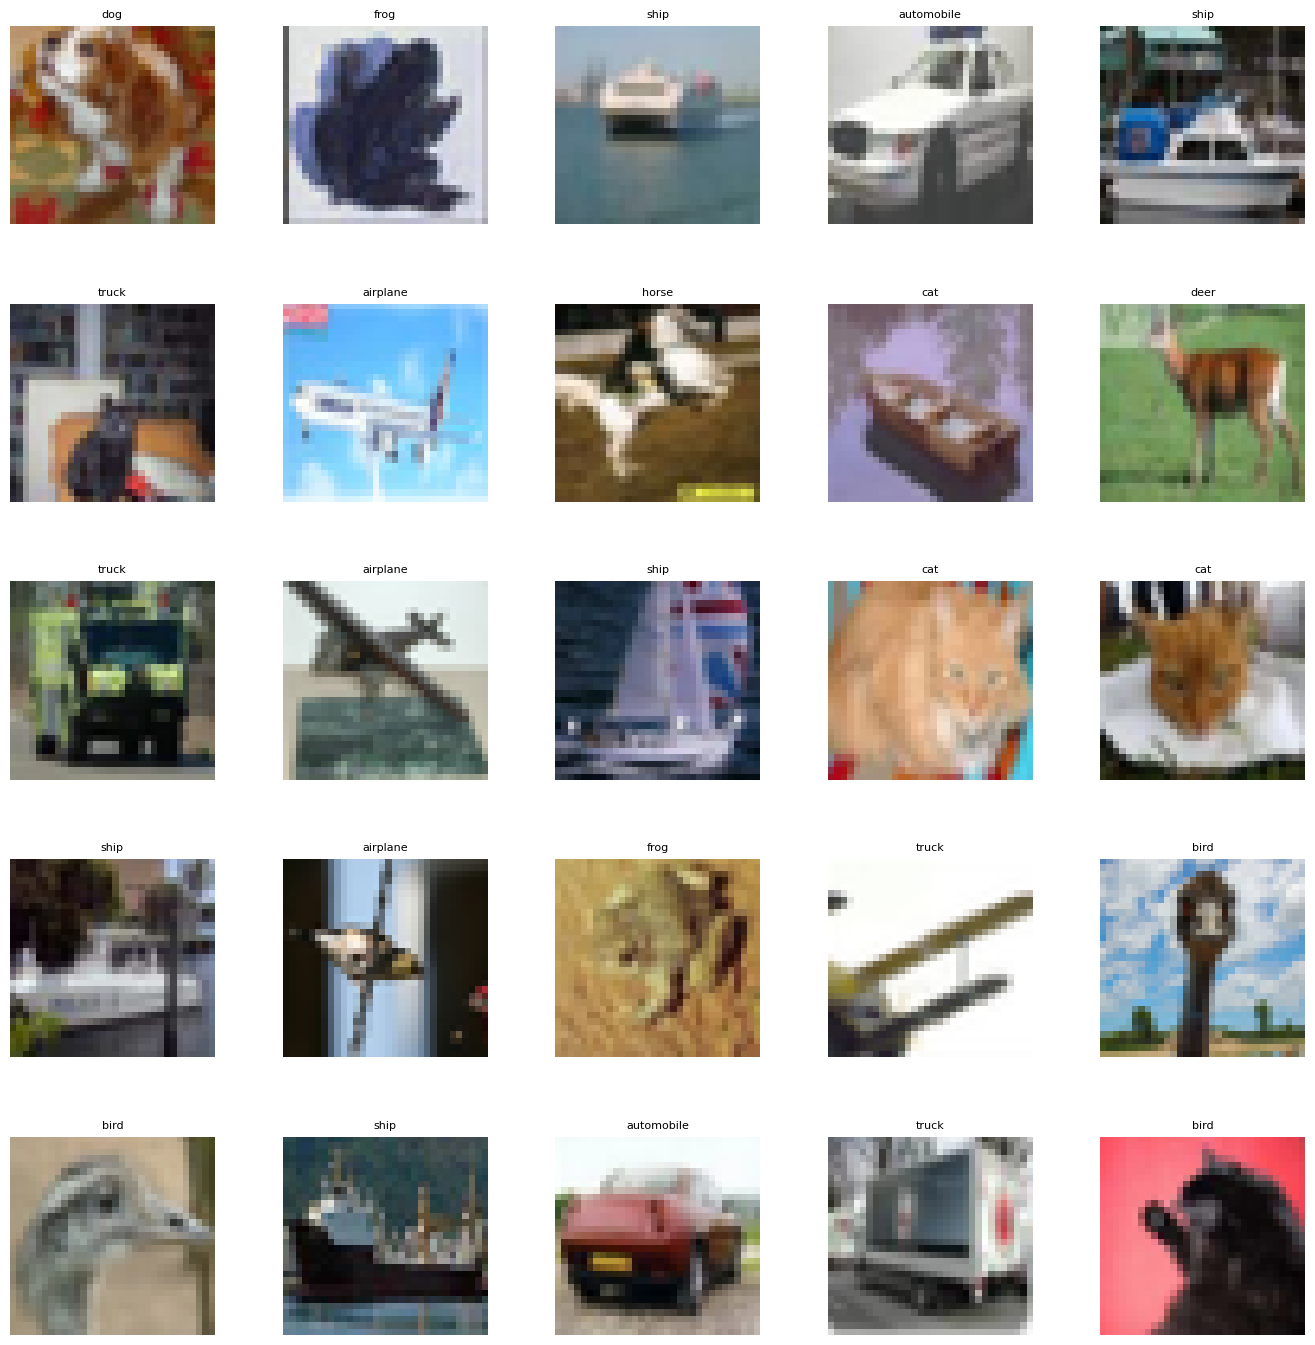

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the dimensions of the plot grid
W_grid = 5
L_grid = 5

# Create a 17x17 grid of subplots
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

# Flaten the grid into 225 array
axes = axes.ravel()

# Get the length of the test dataset
n_test = len(X_test)

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # Create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_test)
    # Read and display an image with the selected index
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8) # Label name is the title of the subplot
    axes[i].axis('off') # Hide the axis

plt.subplots_adjust(hspace=0.4)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  # Plot an image with its predicted and true labels
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    # Set up the plot
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Display the image
    plt.imshow(img, cmap=plt.cm.binary)

    # Determine the predicted label and color based on correctness
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    # Display labels with prediction probabilities
    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
               color=color)

# Plot a bar chart showing the predicted class probabilities
def plot_value_array(i, predictions_array, true_label):
    # Extract relevant data for the specified index
    predictions_array, true_label = predictions_array, int(true_label[i])

    # Set up the bar chart
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])

    # Create the bar chart
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])

    # Determine the predicted label
    predicted_label = np.argmax(predictions_array)

    # Color the bars based on correctness
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 [==============================] - 1s 3ms/step


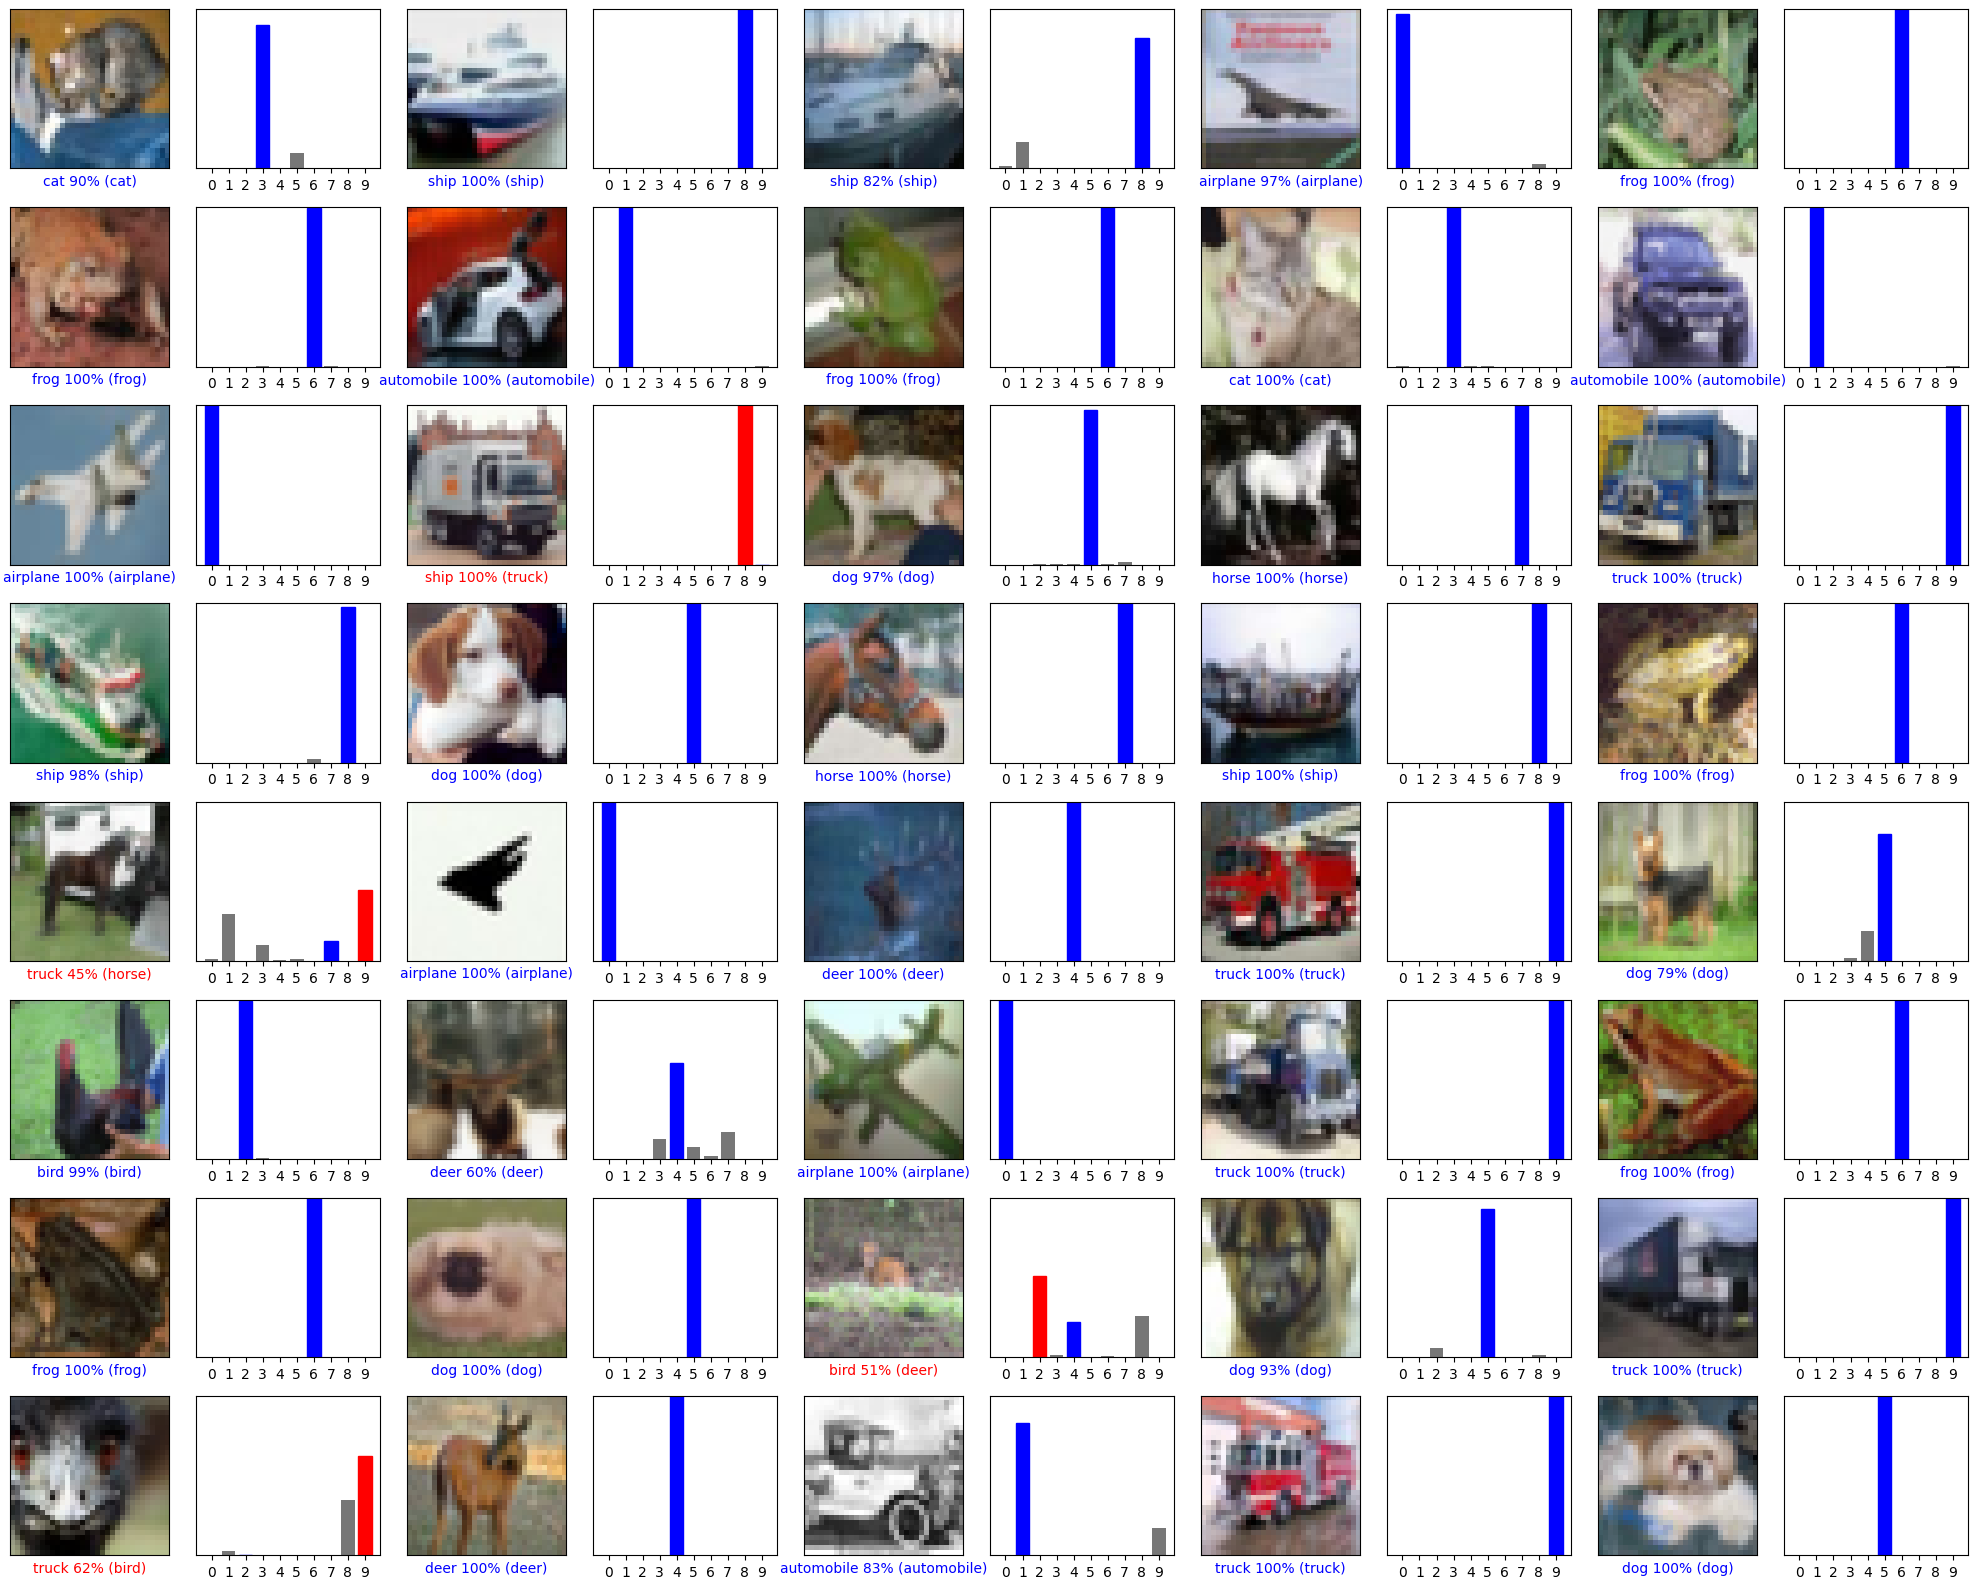

In [ ]:
# Generate predictions on the test set using the trained model
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels
# Color correct predictions in blue and incorrect predictions in red
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols

# Set up the figure for visualising multiple images
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

# Iterate through the images and display them along with predicted and true labels
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)

# Adjust layout for better visualisation
plt.tight_layout()

# Display the plot
plt.show()

## Save the Convolutional Neural Network

In [ ]:
model.save('alexNet-50Epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Cross Fold Validation - Kfold

In [ ]:
# K-Fold Cross-Validation
# Define the number of folds
num_folds = 5

# Define input shape, number of classes, loss function, optimizer, epochs, batch size, and verbosity
input_shape = (32, 32, 3)
no_classes = 10
loss_function = 'sparse_categorical_crossentropy'
optimizer = LegacyAdam()
no_epochs = 10
batch_size = 32
verbosity = 1

# Load CIFAR-10 dataset and normalise the pixel values
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Create the K-Fold object
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialise the fold number
fold_no = 1
# Iterate through folds
for train, test in kfold.split(X_train, y_train):
    # Define a Sequential model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(no_classes, activation='softmax'))

    # Compile the model
    model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

    print('Training for fold ', fold_no)

    # Train the model on the current fold
    history = model.fit(X_train[train], y_train[train], batch_size=batch_size, epochs=no_epochs, verbose=verbosity)

    # Evaluate the model on the validation set
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print('Score for fold ', fold_no)
    print(model.metrics_names[0], scores[0])
    print(model.metrics_names[1], scores[1]*100)

    # Move to the next fold
    fold_no += 1

Training for fold  1
Epoch 1/10
1250/1250 [==============================] - 5s 3ms/step - loss: 1.4645 - accuracy: 0.4656
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0690 - accuracy: 0.6198
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8926 - accuracy: 0.6851
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7576 - accuracy: 0.7351
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6419 - accuracy: 0.7761
Epoch 6/10
1250/1250 [==============================] - 4s 4ms/step - loss: 0.5312 - accuracy: 0.8134
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4367 - accuracy: 0.8459
Epoch 8/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.3465 - accuracy: 0.8785
Epoch 9/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2770 - accuracy: 0.9016
Epoch 10/10
1250/1250 [==============================] - 4s 3